In [1]:
pip install pyspark

In [2]:
pip install xgboost

In [8]:
# Import pyspark
import pyspark
from pyspark import SparkConf
from pyspark.ml.feature import (
    StringIndexer,
    OneHotEncoder,
    VectorAssembler,
    StandardScaler,
)
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator, ClusteringEvaluator

from pyspark.sql.types import FloatType, StringType, DoubleType
from pyspark.sql import functions as F
from pyspark.sql import SparkSession

# Import numpy, pandas, matpoltlib, seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn import metrics

# import xgboost
import xgboost as xgb

# Import keras
import keras
from keras import Sequential, regularizers
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers import Dense, Dropout, Activation


sns.set_style("whitegrid")  # Set style of seaborn

In [5]:
pip install --upgrade keras


In [9]:
# Create SparkSession in local environment
spark = (
    SparkSession.builder.appName("Telecom_Churn")  # create a name
    .config("spark.executor.memory", "10g")  # Maximum amount of memory allowed
    .config("spark.executor.cores", "3")  # Maximum cpu threads allowed
    .config("spark.cores.max", "3")
    .config("spark.driver.memory", "10g")
    .config("spark.sql.broadcastTimeout", "9000")
    .getOrCreate()
)
SparkConf().getAll()

[('spark.app.name', 'Telecom_Churn'),
 ('spark.app.submitTime', '1706014967857'),
 ('spark.sql.broadcastTimeout', '9000'),
 ('spark.executor.memory', '10g'),
 ('spark.driver.memory', '10g'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.cores', '3'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.cores.max', '3')]

In [55]:
def load(path, show_num=None, printable=True):
    """
    read csv file, drop null values, print the length of the rows
    """
    data = spark.read.csv(path, header="true", inferSchema=True)
    data = data.na.drop()
    if show_num:
        data.show(show_num)

    if printable == True:
        data.printSchema()
        print("Length:", data.count())
    return data

In [56]:
path = "cell2celltrain.csv"
df = load(path)
df.select("MonthlyRevenue").describe().show()


root
 |-- CustomerID: integer (nullable = true)
 |-- Churn: string (nullable = true)
 |-- MonthlyRevenue: string (nullable = true)
 |-- MonthlyMinutes: string (nullable = true)
 |-- TotalRecurringCharge: string (nullable = true)
 |-- DirectorAssistedCalls: string (nullable = true)
 |-- OverageMinutes: string (nullable = true)
 |-- RoamingCalls: string (nullable = true)
 |-- PercChangeMinutes: string (nullable = true)
 |-- PercChangeRevenues: string (nullable = true)
 |-- DroppedCalls: double (nullable = true)
 |-- BlockedCalls: double (nullable = true)
 |-- UnansweredCalls: double (nullable = true)
 |-- CustomerCareCalls: double (nullable = true)
 |-- ThreewayCalls: double (nullable = true)
 |-- ReceivedCalls: double (nullable = true)
 |-- OutboundCalls: double (nullable = true)
 |-- InboundCalls: double (nullable = true)
 |-- PeakCallsInOut: double (nullable = true)
 |-- OffPeakCallsInOut: double (nullable = true)
 |-- DroppedBlockedCalls: double (nullable = true)
 |-- CallForwardingC

# ETL

In [57]:
# Delete the rows with 'NA' values
for column in df.columns:
    if df.schema[column].dataType == pyspark.sql.types.StringType():
        df = df.filter(df[column] != "NA")

In [58]:
# Check the description of Churn column
df.select("Churn").describe().show()

+-------+-----+
|summary|Churn|
+-------+-----+
|  count|49752|
|   mean| NULL|
| stddev| NULL|
|    min|   No|
|    max|  Yes|
+-------+-----+



In [59]:
columns_string = [
    column
    for column in df.columns
    if df.schema[column].dataType == pyspark.sql.types.StringType()
]
columns_string

['Churn',
 'MonthlyRevenue',
 'MonthlyMinutes',
 'TotalRecurringCharge',
 'DirectorAssistedCalls',
 'OverageMinutes',
 'RoamingCalls',
 'PercChangeMinutes',
 'PercChangeRevenues',
 'ServiceArea',
 'Handsets',
 'HandsetModels',
 'CurrentEquipmentDays',
 'AgeHH1',
 'AgeHH2',
 'ChildrenInHH',
 'HandsetRefurbished',
 'HandsetWebCapable',
 'TruckOwner',
 'RVOwner',
 'Homeownership',
 'BuysViaMailOrder',
 'RespondsToMailOffers',
 'OptOutMailings',
 'NonUSTravel',
 'OwnsComputer',
 'HasCreditCard',
 'NewCellphoneUser',
 'NotNewCellphoneUser',
 'OwnsMotorcycle',
 'HandsetPrice',
 'MadeCallToRetentionTeam',
 'CreditRating',
 'PrizmCode',
 'Occupation',
 'MaritalStatus']

In [60]:
df.createOrReplaceTempView("df")

#distribution of picked columns
spark.sql(
    "SELECT \
            Churn, \
            CAST (avg(MonthlyRevenue) as decimal(8,2)) as avg_MonthlyRevenue, \
            CAST (avg(MonthlyMinutes) as decimal(8,2)) as avg_MonthlyMinutes, \
            CAST (avg(CurrentEquipmentDays) as decimal(8,2)) as avg_CurrentEquipmentDays, \
            CAST (avg(TotalRecurringCharge) as decimal(8,2)) as avg_TotalRecurringCharge, \
            CAST (avg(OverageMinutes) as decimal(8,2)) as avg_OverageMinutes, \
            CAST (avg(RoamingCalls) as decimal(8,2)) as avg_RoamingCalls \
            FROM df GROUP BY Churn"
).show()

+-----+------------------+------------------+------------------------+------------------------+------------------+----------------+
|Churn|avg_MonthlyRevenue|avg_MonthlyMinutes|avg_CurrentEquipmentDays|avg_TotalRecurringCharge|avg_OverageMinutes|avg_RoamingCalls|
+-----+------------------+------------------+------------------------+------------------------+------------------+----------------+
|   No|             59.06|            541.81|                  363.64|                   47.72|             38.82|            1.16|
|  Yes|             57.87|            483.16|                  420.85|                   44.62|             42.08|            1.40|
+-----+------------------+------------------+------------------------+------------------------+------------------+----------------+



In [61]:
# Check the values of string columns
df.select([column for column in df.columns if column in columns_string]).show(1)

+-----+--------------+--------------+--------------------+---------------------+--------------+------------+-----------------+------------------+-----------+--------+-------------+--------------------+------+------+------------+------------------+-----------------+----------+-------+-------------+----------------+--------------------+--------------+-----------+------------+-------------+----------------+-------------------+--------------+------------+-----------------------+------------+---------+------------+-------------+
|Churn|MonthlyRevenue|MonthlyMinutes|TotalRecurringCharge|DirectorAssistedCalls|OverageMinutes|RoamingCalls|PercChangeMinutes|PercChangeRevenues|ServiceArea|Handsets|HandsetModels|CurrentEquipmentDays|AgeHH1|AgeHH2|ChildrenInHH|HandsetRefurbished|HandsetWebCapable|TruckOwner|RVOwner|Homeownership|BuysViaMailOrder|RespondsToMailOffers|OptOutMailings|NonUSTravel|OwnsComputer|HasCreditCard|NewCellphoneUser|NotNewCellphoneUser|OwnsMotorcycle|HandsetPrice|MadeCallToReten

In [62]:
# Based on the values of the string columns, select the list of columns for StringIndexer
columns_for_indexer = [
    "Churn",
    "ChildrenInHH",
    "HandsetRefurbished",
    "HandsetWebCapable",
    "TruckOwner",
    "RVOwner",
    "Homeownership",
    "BuysViaMailOrder",
    "RespondsToMailOffers",
    "OptOutMailings",
    "NonUSTravel",
    "OwnsComputer",
    "HasCreditCard",
    "NewCellphoneUser",
    "NotNewCellphoneUser",
    "OwnsMotorcycle",
    "MadeCallToRetentionTeam",
    "MaritalStatus",
]

In [63]:
# Loop the list and use StringIndexer encodes the string columns of labels(Yes or No) to columns of label indices(1 or 0)
for column in columns_for_indexer:
    indexer = StringIndexer(inputCol=column, outputCol=column + "Index")
    df = indexer.fit(df).transform(df)

In [64]:
# Drop the original string columns of labels
df = df.select([column for column in df.columns if column not in columns_for_indexer])


In [65]:
# Check the Churn column again to confirm the result
df.select("ChurnIndex").describe().show()

+-------+-------------------+
|summary|         ChurnIndex|
+-------+-------------------+
|  count|              49752|
|   mean|0.28632014793375143|
| stddev|0.45204538278095574|
|    min|                0.0|
|    max|                1.0|
+-------+-------------------+



In [66]:
# Replace unknown values to 0 for Price Column
df = df.replace(to_replace={"Unknown": "0"}, subset=["HandsetPrice"])

In [67]:
# Delete the rows with 'NA' values
for column in df.columns:
    if df.schema[column].dataType == pyspark.sql.types.StringType():
        df = df.filter(df[column] != "Unknown")

In [68]:
# Another Iteration for feature engineering
columns_string = [
    column
    for column in df.columns
    if df.schema[column].dataType == pyspark.sql.types.StringType()
]
columns_string

['MonthlyRevenue',
 'MonthlyMinutes',
 'TotalRecurringCharge',
 'DirectorAssistedCalls',
 'OverageMinutes',
 'RoamingCalls',
 'PercChangeMinutes',
 'PercChangeRevenues',
 'ServiceArea',
 'Handsets',
 'HandsetModels',
 'CurrentEquipmentDays',
 'AgeHH1',
 'AgeHH2',
 'HandsetPrice',
 'CreditRating',
 'PrizmCode',
 'Occupation']

In [69]:
# Mapping string values into integer based on its values
mapping_PrizmCode = {"Other": "0", "Suburban": "1", "Town": "2", "Rural": "3"}
df = df.replace(to_replace=mapping_PrizmCode, subset=["PrizmCode"])

In [70]:
# Prepare the list of columns to be transformed into float
columns_to_float = [
    "MonthlyRevenue",
    "MonthlyMinutes",
    "TotalRecurringCharge",
    "DirectorAssistedCalls",
    "OverageMinutes",
    "RoamingCalls",
    "PercChangeMinutes",
    "PercChangeRevenues",
]

In [71]:
# Transform ServiceArea and CreditRating columns only to keep the int value
df = df.withColumn("ServiceArea", df["ServiceArea"].substr(-3, 3))
df = df.withColumn("CreditRating", df["CreditRating"].substr(1, 1))

In [72]:
# Transform the type of columns to float
for column in columns_to_float:
    df = df.withColumn(column, df[column].cast("float"))

In [73]:
# Create a Pandas DataFrame for data visualization
df_pd = df.toPandas()

In [76]:
sns.set(style="whitegrid")

In [78]:
sns.color_palette("tab10")

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

<ipython-input-83-43f53e3a9b3d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Occupation", y="MonthlyRevenue", data=graph, palette='tab10')


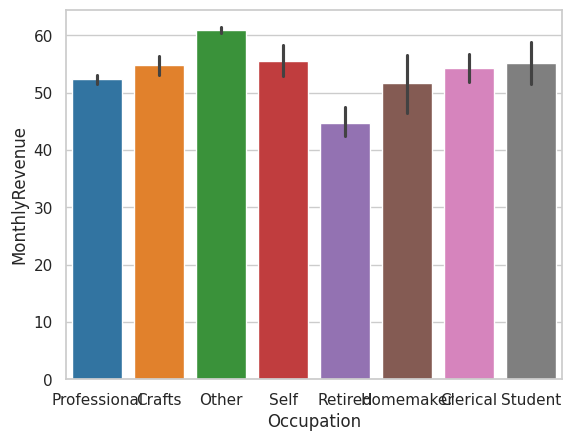

In [83]:
# Before transform the type of Occupation column, let's check it's distribution first
graph = df_pd[["Occupation", "MonthlyRevenue"]]
ax = sns.barplot(x="Occupation", y="MonthlyRevenue", data=graph, palette='tab10')

In [84]:
# Transform string values to numbers using mapping
temp = (
    df_pd.loc[:, ["Occupation", "MonthlyRevenue"]]
    .groupby("Occupation")
    .mean()
    .sort_values(["MonthlyRevenue"], ascending=[0])
)

mapping_Occupation = dict([temp.index[i], str(i)] for i in range(len(temp)))
print(mapping_Occupation)

df = df.replace(to_replace=mapping_Occupation, subset=["Occupation"])

{'Other': '0', 'Self': '1', 'Student': '2', 'Crafts': '3', 'Clerical': '4', 'Professional': '5', 'Homemaker': '6', 'Retired': '7'}


In [85]:
df.describe()

DataFrame[summary: string, CustomerID: string, MonthlyRevenue: string, MonthlyMinutes: string, TotalRecurringCharge: string, DirectorAssistedCalls: string, OverageMinutes: string, RoamingCalls: string, PercChangeMinutes: string, PercChangeRevenues: string, DroppedCalls: string, BlockedCalls: string, UnansweredCalls: string, CustomerCareCalls: string, ThreewayCalls: string, ReceivedCalls: string, OutboundCalls: string, InboundCalls: string, PeakCallsInOut: string, OffPeakCallsInOut: string, DroppedBlockedCalls: string, CallForwardingCalls: string, CallWaitingCalls: string, MonthsInService: string, UniqueSubs: string, ActiveSubs: string, ServiceArea: string, Handsets: string, HandsetModels: string, CurrentEquipmentDays: string, AgeHH1: string, AgeHH2: string, RetentionCalls: string, RetentionOffersAccepted: string, ReferralsMadeBySubscriber: string, IncomeGroup: string, AdjustmentsToCreditRating: string, HandsetPrice: string, CreditRating: string, PrizmCode: string, Occupation: string, C

In [86]:
# Prepare the list of columns to be transformed into integer
columns_to_int = [
    "Handsets",
    "HandsetModels",
    "CurrentEquipmentDays",
    "AgeHH1",
    "AgeHH2",
    "HandsetPrice",
    "ServiceArea",
    "CreditRating",
    "PrizmCode",
    "Occupation",
    "ChurnIndex",
    "ChildrenInHHIndex",
    "HandsetRefurbishedIndex",
    "HandsetWebCapableIndex",
    "TruckOwnerIndex",
    "RVOwnerIndex",
    "HomeownershipIndex",
    "BuysViaMailOrderIndex",
    "RespondsToMailOffersIndex",
    "OptOutMailingsIndex",
    "NonUSTravelIndex",
    "OwnsComputerIndex",
    "HasCreditCardIndex",
    "NewCellphoneUserIndex",
    "NotNewCellphoneUserIndex",
    "OwnsMotorcycleIndex",
    "MadeCallToRetentionTeamIndex",
    "MaritalStatusIndex",
]

In [87]:
# Transform the type of columns to integer
for column in columns_to_int:
    df = df.withColumn(column, df[column].cast("int"))

# Analysis & Viz

In [88]:
# Go through the dataset check the distribution of each feature
for i in range(len(df.columns) // 6 + 1):
    df.describe(df.columns[6 * i : 6 * (i + 1)]).show()

+-------+------------------+------------------+-----------------+--------------------+---------------------+-----------------+
|summary|        CustomerID|    MonthlyRevenue|   MonthlyMinutes|TotalRecurringCharge|DirectorAssistedCalls|   OverageMinutes|
+-------+------------------+------------------+-----------------+--------------------+---------------------+-----------------+
|  count|             49752|             49752|            49752|               49752|                49752|            49752|
|   mean|  3200957.68290722| 58.71737385609968|525.0214664737096|   46.83496140858659|   0.8918407307885328|39.75404003859141|
| stddev|116469.39654597394|44.317243781725836|528.5101549841826|  23.759492302348463|   2.2247253274787235|96.09160595755439|
|    min|           3000002|             -6.17|              0.0|                -6.0|                  0.0|              0.0|
|    max|           3399974|           1223.38|           7359.0|               400.0|               159.39|   

In [89]:
# Create a new Pandas DataFrame for data visualization
df_pd = df.toPandas()

In [90]:
# Define Catplot function and Barplot function
def cat_plot(feature, cut=12):
    temp = df_pd.loc[:, [feature, "ChurnIndex"]]
    temp[feature + "_binned"] = pd.qcut(temp[feature], cut, duplicates="drop")
    ax = sns.catplot(
        x="ChurnIndex",
        y=feature + "_binned",
        data=temp,
        kind="bar",
        height=5,
        aspect=2.7,
    )


def bar_plot(feature, cut=False, logscale=False, drop_zero=False):
    if drop_zero:
        temp = df_pd[df_pd[feature] != 0].loc[:, [feature, "ChurnIndex"]]
    else:
        temp = df_pd.loc[:, [feature, "ChurnIndex"]]

    if cut > 0:
        temp[feature + "_binned"] = pd.qcut(temp[feature], cut, duplicates="drop")
        ax = sns.barplot(x=feature + "_binned", y="ChurnIndex", data=temp)
    else:
        ax = sns.barplot(x=feature, y="ChurnIndex", data=temp)

    if logscale:
        ax.set_yscale("log")

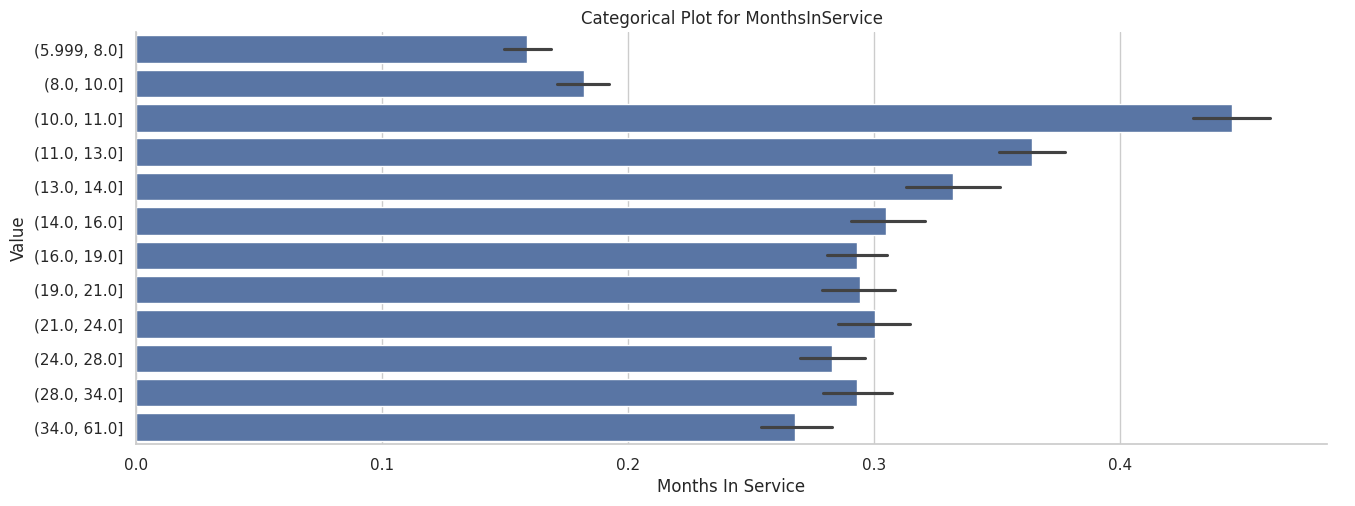

In [100]:
# Catplot function plot the distribution of MonthsInService
cat_plot("MonthsInService", cut=12)


# labels and a title
plt.xlabel('Months In Service')
plt.ylabel('Value')
plt.title('Categorical Plot for MonthsInService')


plt.show()


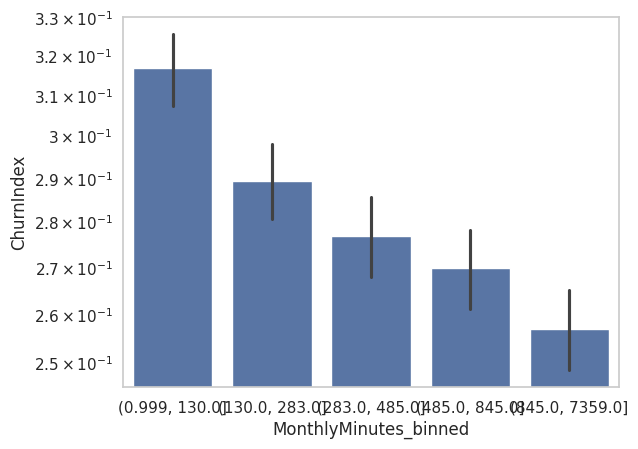

In [101]:
# Use defined Barplot function plot the distribution of MonthlyMinutes
bar_plot("MonthlyMinutes", cut=5, logscale=True, drop_zero=True)

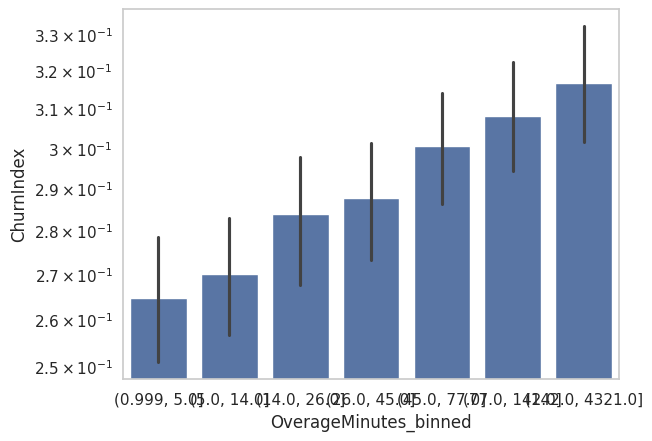

In [102]:
# Use defined Barplot function plot the distribution of OverageMinutes
bar_plot("OverageMinutes", cut=7, logscale=True, drop_zero=True)

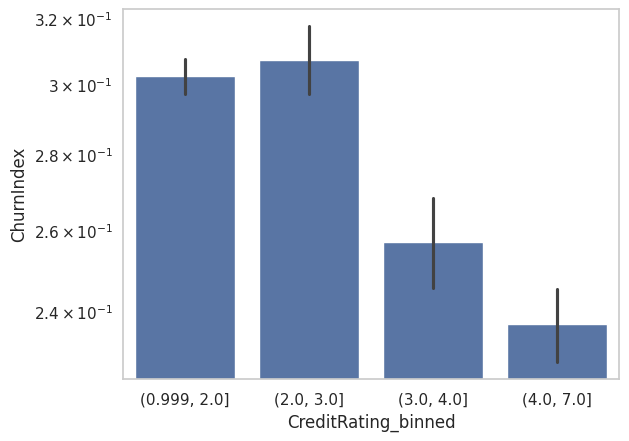

In [103]:
# Use defined Barplot function plot the distribution of CreditRating
bar_plot("CreditRating", cut=5, logscale=True)

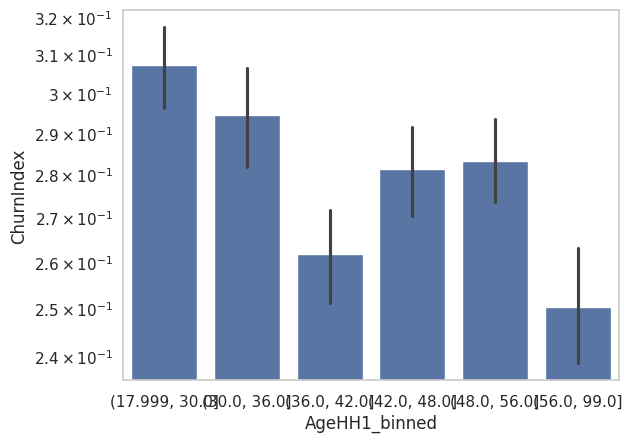

In [107]:
# Use defined Barplot function plot the distribution of AgeHH1
bar_plot("AgeHH1", cut=6, logscale=True, drop_zero=True)

<ipython-input-128-32d8d81a8d25>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="HandsetRefurbished", y="ChurnIndex", data=temp, ax=axs[0],palette='tab10')
<ipython-input-128-32d8d81a8d25>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="HandsetWebCapable", y="ChurnIndex", data=temp, ax=axs[1],palette='tab10')
<ipython-input-128-32d8d81a8d25>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="MadeCallToRetentionTeam", y="ChurnIndex", data=temp, ax=axs[2],palette='tab10')


<Axes: xlabel='MadeCallToRetentionTeam', ylabel='ChurnIndex'>

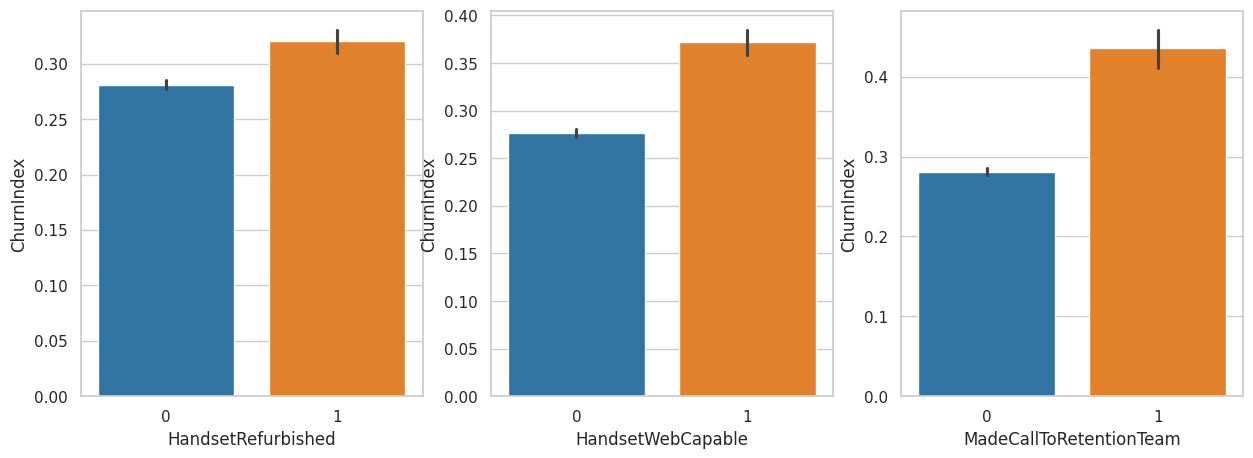

In [128]:
# Subplots the distribution of HandsetRefurbished, HandsetWebCapable and MadeCallToRetentionTeam into one graph
feature = [
    "HandsetRefurbishedIndex",
    "HandsetWebCapableIndex",
    "MadeCallToRetentionTeamIndex",
    "ChurnIndex",
]
temp = df_pd.loc[:, feature]
temp.columns = [
    "HandsetRefurbished",
    "HandsetWebCapable",
    "MadeCallToRetentionTeam",
    "ChurnIndex",
]

fig, axs = plt.subplots(figsize=(15, 5), ncols=3)
sns.barplot(x="HandsetRefurbished", y="ChurnIndex", data=temp, ax=axs[0],palette='tab10')
sns.barplot(x="HandsetWebCapable", y="ChurnIndex", data=temp, ax=axs[1],palette='tab10')
sns.barplot(x="MadeCallToRetentionTeam", y="ChurnIndex", data=temp, ax=axs[2],palette='tab10')

# Data Preprocessing 2

In [110]:
# Create column list for VectorAssembler
inputcols = [
    column for column in df.columns if column not in ["CustomerID", "ChurnIndex"]
]

In [111]:
# Use vectorAssembler transform the given list of columns into a single vector column.
vectorAssembler = VectorAssembler(inputCols=inputcols, outputCol="features")
features_vectorized = vectorAssembler.transform(df)
features_vectorized = features_vectorized.withColumnRenamed("ChurnIndex", "label")

In [112]:
# StandardScaler
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(features_vectorized)

# Normalize each feature to have unit standard deviation.
scaledData = scalerModel.transform(features_vectorized)
scaledData.show()

+----------+--------------+--------------+--------------------+---------------------+--------------+------------+-----------------+------------------+------------+------------+---------------+-----------------+-------------+-------------+-------------+------------+--------------+-----------------+-------------------+-------------------+----------------+---------------+----------+----------+-----------+--------+-------------+--------------------+------+------+--------------+-----------------------+-------------------------+-----------+-------------------------+------------+------------+---------+----------+-----+-----------------+-----------------------+----------------------+---------------+------------+------------------+---------------------+-------------------------+-------------------+----------------+-----------------+------------------+---------------------+------------------------+-------------------+----------------------------+------------------+--------------------+----------

In [48]:
from pyspark.ml.feature import StandardScaler
from pyspark.sql import SparkSession


In [50]:
spark.sparkContext.setLogLevel("DEBUG")



In [113]:
# Check the distribution of label
scaledData.select("label").groupBy("label").count().collect()

[Row(label=1, count=14245), Row(label=0, count=35507)]

In [114]:
# Down-sampling
scaledData_ds, _ = scaledData.filter(scaledData["label"] == 0.0).randomSplit([0.4, 0.6])
scaledData_ds = scaledData.filter(scaledData["label"] == 1.0).union(scaledData_ds)
scaledData_ds.select("label").groupBy("label").count().collect()

[Row(label=1, count=14245), Row(label=0, count=14221)]

# Pred Model Prep

In [115]:
# Split dataset into train and test set
train, test = scaledData_ds.randomSplit([0.8, 0.2])

In [116]:
# Define plot roc curve function
def plot_roc_curve(model, train, test):
    predictions = model.transform(test)
    predictions_train = model.transform(train)

    results = predictions.select(["probability", "label"])
    results_train = predictions_train.select(["probability", "label"])

    ## prepare score-label set
    results_collect = results.collect()
    results_list = [(float(i[0][0]), 1.0 - float(i[1])) for i in results_collect]

    results_collect_train = results_train.collect()
    results_list_train = [
        (float(i[0][0]), 1.0 - float(i[1])) for i in results_collect_train
    ]

    fpr = dict()
    fpr_train = dict()
    tpr = dict()
    tpr_train = dict()
    roc_auc = dict()
    roc_auc_train = dict()

    y_test = [i[1] for i in results_list]
    y_score = [i[0] for i in results_list]

    y_train = [i[1] for i in results_list_train]
    y_score_train = [i[0] for i in results_list_train]

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    fpr_train, tpr_train, _ = roc_curve(y_train, y_score_train)
    roc_auc_train = auc(fpr_train, tpr_train)

    plt.figure()
    plt.plot(fpr, tpr, label="ROC curve on testing set (area = %0.2f)" % roc_auc)
    plt.plot(
        fpr_train,
        tpr_train,
        label="ROC curve on training set (area = %0.2f)" % roc_auc_train,
    )
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()

#Random Forest Classifier

In [117]:
#Random Forest Classifier
# Validation for hyper-parameter tuning.
# Randomly splits the input dataset into train and validation sets,
# and uses evaluation metric on the validation set to select the best model.
rf = RandomForestClassifier(
    featuresCol="features", labelCol="label", predictionCol="prediction", maxBins=16
)

# Use a ParamGridBuilder to construct a grid of parameters to search over.
# TrainValidationSplit will try all combinations of values and determine best model using the evaluator.
paramGrid = (
    ParamGridBuilder()
    .addGrid(rf.maxDepth, [8, 10, 12])
    .addGrid(rf.minInstancesPerNode, [1, 3, 5, 10])
    .addGrid(rf.numTrees, [50, 100])
    .build()
)

# In this case the estimator is BinaryClassificationEvaluator
# A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
tvs = TrainValidationSplit(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=BinaryClassificationEvaluator(),
    trainRatio=0.8,
)  # 80% of the data will be used for training, 20% for validation.

# Run TrainValidationSplit, and choose the best set of parameters.
model = tvs.fit(train)

In [ ]:
# Predictions on the test and train data using Decision Tree model
X_test_pred = rf.predict(Xtest)
X_train_pred = rf.predict(Xtrain)

# Model Accuracy
print('Basic Decision Tree')
print("Train Accuracy:", metrics.accuracy_score(Ytrain, X_train_pred))
print("Test Accuracy:", metrics.accuracy_score(Ytest, X_test_pred))

# Confusion Matrix for Decision Tree
print("Confusion Matrix for Decision Tree:")
print(confusion_matrix(Ytest, X_test_pred))

# Max Depth and Number of Leaves in the Decision Tree
print("Max Depth:", dt.get_depth())
print("Number of Leaves:", dt.get_n_leaves())

# Printing precision, recall, and other classification metrics
print('Printing precision, recall, and other metrics')
print(metrics.classification_report(Ytest, X_test_pred))

In [118]:
# From the best model take chosen hyper-parameters
best_model = model.bestModel.extractParamMap()

for key in best_model.keys():
    print(str(key).split("_")[-1], ":", best_model[key])

bootstrap : True
cacheNodeIds : False
checkpointInterval : 10
featureSubsetStrategy : auto
featuresCol : features
impurity : gini
labelCol : label
leafCol : 
maxBins : 16
maxDepth : 12
maxMemoryInMB : 256
minInfoGain : 0.0
minInstancesPerNode : 1
minWeightFractionPerNode : 0.0
numTrees : 50
predictionCol : prediction
probabilityCol : probability
rawPredictionCol : rawPrediction
seed : -2306131251422091267
subsamplingRate : 1.0


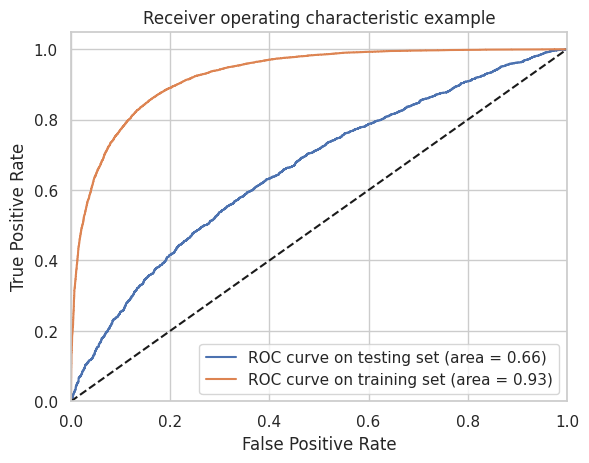

In [119]:
plot_roc_curve(model, train, test)


In [121]:
# Evaluate the feature importances and plot the charts for most important 20 features
importance = model.bestModel.featureImportances
features_list = inputcols
feature_importance = pd.DataFrame(
    data={"features_list": features_list, "importance": importance}
)


In [124]:
feature_importance = feature_importance.sort_values(by="importance", ascending=False)[ :20]


TypeError: '<' not supported between instances of 'SparseVector' and 'SparseVector'

# Grad Boosted Tree Classifier ( GBT )


In [129]:
# Validation for hyper-parameter tuning.
# Randomly splits the input dataset into train and validation sets,
# and uses evaluation metric on the validation set to select the best model.
gbt = GBTClassifier(
    featuresCol="features", labelCol="label", predictionCol="prediction"
)

# Use a ParamGridBuilder to construct a grid of parameters to search over.
# TrainValidationSplit will try all combinations of values and determine best model using the evaluator.
paramGrid = (
    ParamGridBuilder()
    .addGrid(gbt.maxDepth, [8, 10])
    .addGrid(gbt.minInstancesPerNode, [5, 20, 50])
    .addGrid(gbt.maxIter, [10, 20])
    .build()
)

# In this case the estimator is BinaryClassificationEvaluator
# A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
tvs = TrainValidationSplit(
    estimator=gbt,
    estimatorParamMaps=paramGrid,
    evaluator=BinaryClassificationEvaluator(),
    trainRatio=0.8,
)  # 80% of the data will be used for training, 20% for validation.

# Run TrainValidationSplit, and choose the best set of parameters.
model = tvs.fit(train)

# Make predictions on test data. model is the model with combination of parameters that performed best.
model.transform(test).select("features", "label", "prediction").show(10)

+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|(56,[0,1,2,3,6,7,...|    1|       1.0|
|(56,[0,1,2,6,7,8,...|    1|       1.0|
|(56,[0,1,2,3,4,5,...|    1|       0.0|
|(56,[0,1,2,3,5,6,...|    1|       0.0|
|(56,[0,1,2,3,6,7,...|    1|       1.0|
|(56,[0,1,2,6,9,10...|    1|       1.0|
|(56,[0,1,2,4,6,7,...|    1|       1.0|
|(56,[0,1,2,3,6,7,...|    1|       0.0|
|(56,[0,1,2,6,7,8,...|    1|       1.0|
|(56,[0,1,2,3,4,5,...|    1|       0.0|
+--------------------+-----+----------+
only showing top 10 rows



In [131]:
# From the best model take chosen hyper-parameters
best_model = model.bestModel.extractParamMap()

for key in best_model.keys():
    print(str(key).split("_")[-1], ":", best_model[key])

cacheNodeIds : False
checkpointInterval : 10
featureSubsetStrategy : all
featuresCol : features
impurity : variance
labelCol : label
leafCol : 
lossType : logistic
maxBins : 32
maxDepth : 8
maxIter : 20
maxMemoryInMB : 256
minInfoGain : 0.0
minInstancesPerNode : 50
minWeightFractionPerNode : 0.0
predictionCol : prediction
probabilityCol : probability
rawPredictionCol : rawPrediction
seed : -3550561963932980373
stepSize : 0.1
subsamplingRate : 1.0
validationTol : 0.01


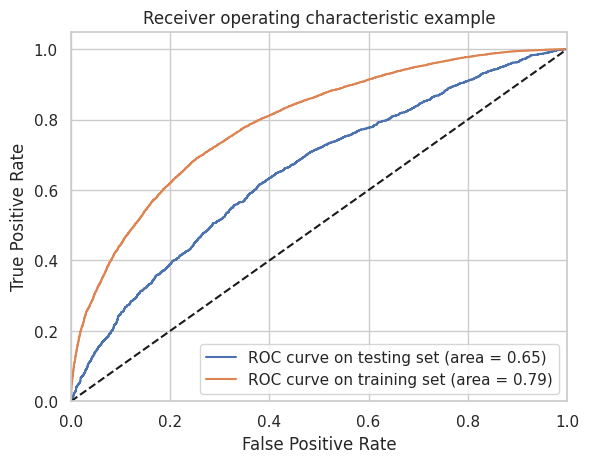

In [132]:
# Use defined function plot roc curve and print roc auc score
plot_roc_curve(model, train, test)

#XGBoos Regressor

In [133]:
# Transofrm scaledData into pandas Dataframe so we can use XGBoost and Keras
dataset = scaledData.toPandas()

# Create revenue loss column as label
dataset["revenue_loss"] = dataset.label * dataset.MonthlyRevenue

# Create the list of features
feature_list = [
    column
    for column in dataset.columns
    if column
    not in ["CustomerID", "label", "features", "revenue_loss", "scaledFeatures"]
]

# Create X, y, and split into train/test sets
X = dataset.loc[:, feature_list]
y = dataset.revenue_loss
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [134]:
# Use GridSearch method to figure the best hyper-parameters
# Parameters to search over with cross-validation
grid_params = [
    {
        "max_depth": [4, 5],
        "learning_rate": [0.1, 1],
        "n_estimators": [10, 100],
        "reg_lambda": [100, 10],
        "objective": ["reg:linear"],
    }
]

xgbr = GridSearchCV(xgb.XGBRegressor(), grid_params, cv=5, scoring="r2")
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)

print("Mean Absolute Error: %r\n" % metrics.mean_absolute_error(y_test, y_pred))
print("Best parameter values: %r\n" % xgbr.best_params_)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:50:13] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:50:13] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:50:13] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:50:14] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:

Mean Absolute Error: 22.37013614736778

Best parameter values: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'objective': 'reg:linear', 'reg_lambda': 100}



<ipython-input-152-a95a2d6e74d9>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


Highest Risk Group(5.00% of total clients) can capture 16.71% of total revenue_loss


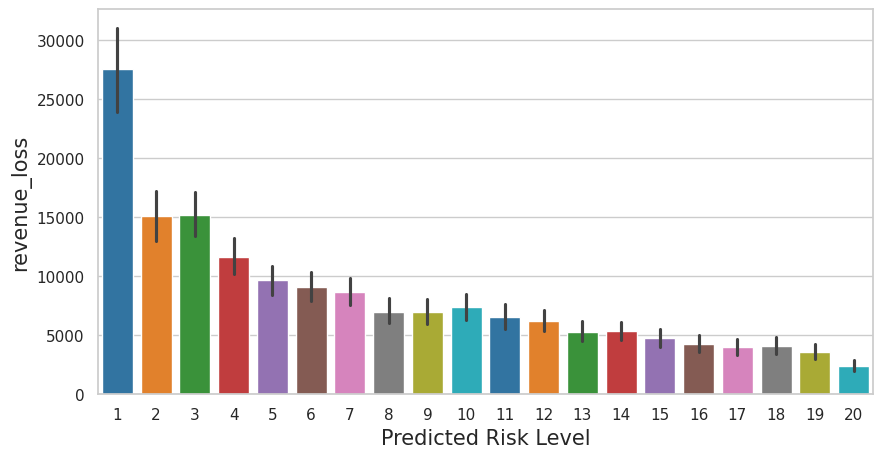

In [152]:
# Plot a chart of how many of total revenue loss can be captured with our predicted highest risk group
temp = X_test.copy()
temp["revenue_loss"] = y_test
temp["y_pred"] = y_pred
n = 20
temp["y_pred_bin"] = pd.qcut(temp["y_pred"], n, duplicates="drop")
l = len(temp["y_pred_bin"].unique())
labels = [l + 1 - i for i in range(1, l + 1)]
temp["y_pred_bin"] = pd.qcut(temp["y_pred"], n, labels=labels, duplicates="drop")
index_amount = temp.index[(temp.y_pred_bin == 1)]
fig = plt.figure(figsize=(10, 5))
labels.sort()
ax = sns.barplot(
    x="y_pred_bin", y="revenue_loss", data=temp, estimator=np.sum, order=labels,palette='tab10'
)
plt.xlabel("Predicted Risk Level", fontsize=15)
plt.ylabel("revenue_loss", fontsize=15)
per = 100 * sum(temp.y_pred_bin == 1) / len(temp.y_pred_bin)
print(
    "Highest Risk Group(%.2f%% of total clients) can capture %.2f%% of total revenue_loss"
    % (
        per,
        100 * temp[(temp.y_pred_bin == 1)].revenue_loss.sum() / temp.revenue_loss.sum(),
    )
)

#Neural Nets to pred Rev Loss

In [136]:
a = 0.0005
drop = 0.2
n = X_train.shape[1]

model = Sequential(
    [
        Dense(
            int(n * 1.2),
            input_dim=n,
            kernel_regularizer=regularizers.l1_l2(l1=a, l2=a),
            activation="relu",
        ),
        Dropout(drop),
        Dense(
            int(n), kernel_regularizer=regularizers.l1_l2(l1=a, l2=a), activation="relu"
        ),
        Dropout(drop),
        Dense(
            int(n * 0.8),
            activation="relu",
            kernel_regularizer=regularizers.l1_l2(l1=a, l2=a),
        ),
        Dense(1),
    ]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [137]:
# Prints a summary representation of model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ dense (Dense)                      │ (None, 67)                    │       3,819 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout (Dropout)                  │ (None, 67)                    │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_1 (Dense)                    │ (None, 56)                    │       3,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout_1 (Dropout)                │ (None, 56)                    │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_2 (Dense)                    │ (None, 44)                    │       2,508 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_3 (Dense)                    │ (None, 1)                     │          45 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 10,180 (39.77 KB)

 Trainable params: 10,180 (39.77 KB)

 Non-trainable params: 0 (0.00 B)

In [138]:
# Configures the model for training and fit the training set
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mae", "accuracy"])
history = model.fit(
    X_train, y_train, validation_split=0.2, epochs=5, verbose=1, shuffle=True
)

Epoch 1/5
995/995 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.0780 - loss: 1485.2527 - mae: 25.3356 - val_accuracy: 2.5122e-04 - val_loss: 1319.0614 - val_mae: 20.1507
Epoch 2/5
995/995 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0043 - loss: 1186.6960 - mae: 23.0113 - val_accuracy: 0.0000e+00 - val_loss: 1215.8274 - val_mae: 21.1752
Epoch 3/5
995/995 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.0035 - loss: 1182.4124 - mae: 22.9950 - val_accuracy: 0.0000e+00 - val_loss: 1224.3408 - val_mae: 20.9763
Epoch 4/5
995/995 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 1.4819e-04 - loss: 1256.5959 - mae: 23.2718 - val_accuracy: 0.0000e+00 - val_loss: 1199.1267 - val_mae: 22.1022
Epoch 5/5
995/995 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 4.7661e-06 - loss: 1154.5989 - mae: 23.2892 - val_accuracy: 1.2561e-04 - val_loss: 1223.0616 - val_mae: 21.4236


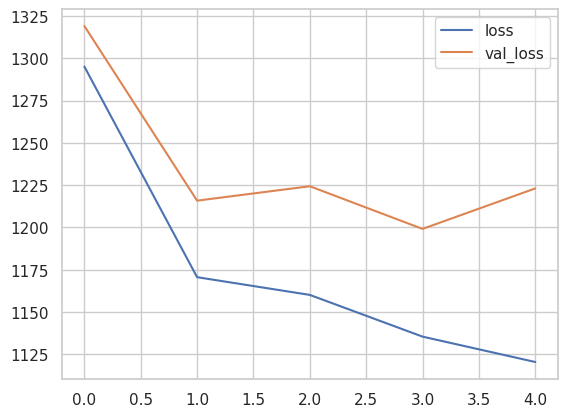

In [139]:
# plot loss metrics
ax1 = plt.plot(history.history["loss"])
ax2 = plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])

In [140]:
# Use model redict test set
y_pred = model.predict(X_test)
y_test = np.array(y_test)

311/311 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<ipython-input-151-a95a2d6e74d9>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


Highest Risk Group(5.00% of total clients) can capture 16.71% of total revenue_loss


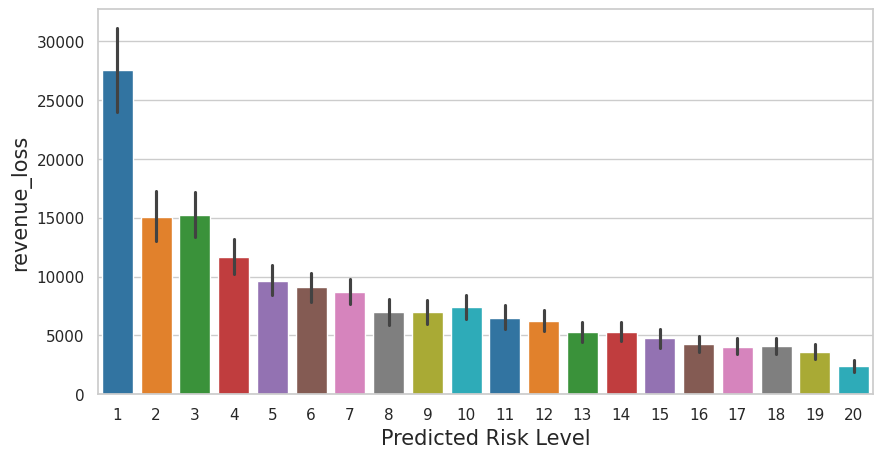

In [151]:
# Plot a chart of how many of total revenue loss can be captured with our predicted highest risk group
temp = X_test.copy()
temp["revenue_loss"] = y_test
temp["y_pred"] = y_pred
n = 20
temp["y_pred_bin"] = pd.qcut(temp["y_pred"], n, duplicates="drop")
l = len(temp["y_pred_bin"].unique())
labels = [l + 1 - i for i in range(1, l + 1)]
temp["y_pred_bin"] = pd.qcut(temp["y_pred"], n, labels=labels, duplicates="drop")
index_amount = temp.index[(temp.y_pred_bin == 1)]
fig = plt.figure(figsize=(10, 5))
labels.sort()
ax = sns.barplot(
    x="y_pred_bin", y="revenue_loss", data=temp, estimator=np.sum, order=labels,palette='tab10'
)
plt.xlabel("Predicted Risk Level", fontsize=15)
plt.ylabel("revenue_loss", fontsize=15)
per = 100 * sum(temp.y_pred_bin == 1) / len(temp.y_pred_bin)
print(
    "Highest Risk Group(%.2f%% of total clients) can capture %.2f%% of total revenue_loss"
    % (
        per,
        100 * temp[(temp.y_pred_bin == 1)].revenue_loss.sum() / temp.revenue_loss.sum(),
    )
)

#Customer Segmentation

In [142]:
# Trains a k-means model
kmeans = KMeans(featuresCol="scaledFeatures", k=4, initSteps=2, tol=0.0001, maxIter=20)
model = kmeans.fit(scaledData)

In [143]:
# Make predictions
predictions = model.transform(scaledData)

In [144]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.013186582540394124


In [145]:
# Create a Pandas DataFrame for data visualization
cluster = predictions.toPandas()

<ipython-input-149-0869fe9a3c11>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="prediction", y=temp_list[i], data=temp, ax=axs[i],palette='tab10')
<ipython-input-149-0869fe9a3c11>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="prediction", y=temp_list[i], data=temp, ax=axs[i],palette='tab10')
<ipython-input-149-0869fe9a3c11>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="prediction", y=temp_list[i], data=temp, ax=axs[i],palette='tab10')
<ipython-input-149-0869fe9a3c11>:9: FutureWarning: 

Passing `palette` witho

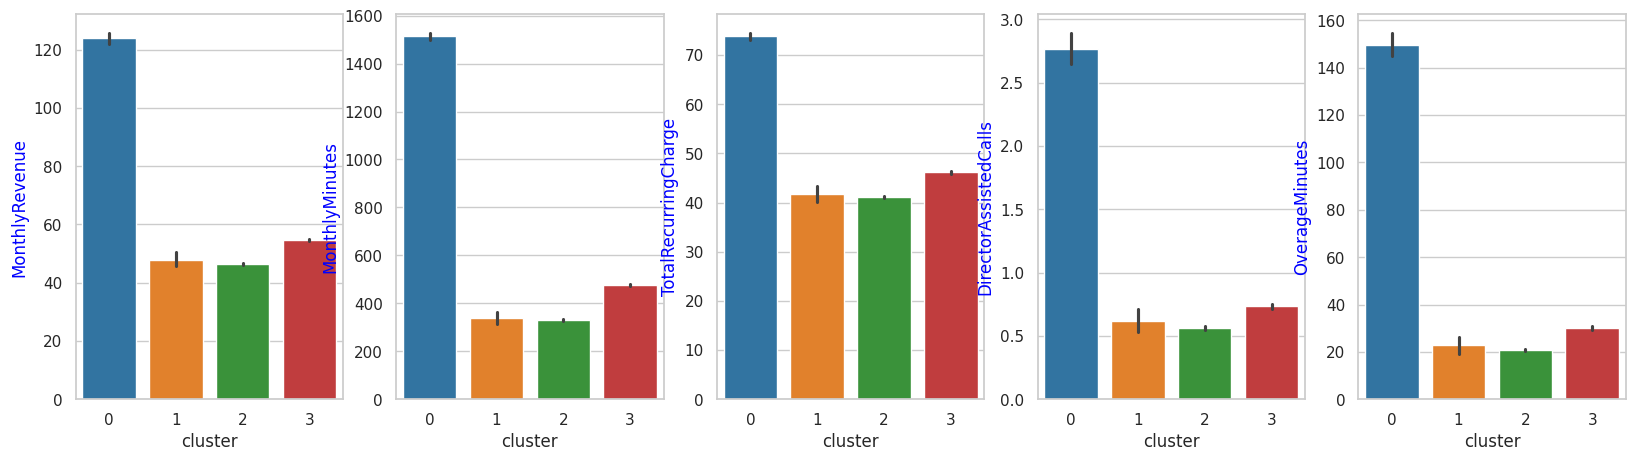

In [149]:
# Compare the different distributions of each cluster
temp_list = list(feature_importance.iloc[:5, 0])
temp_list.append("prediction")
temp = cluster.loc[:, temp_list]

fig, axs = plt.subplots(figsize=(20, 5), ncols=len(temp_list) - 1)

for i in range(len(temp_list) - 1):
    ax = sns.barplot(x="prediction", y=temp_list[i], data=temp, ax=axs[i],palette='tab10')
    ax.set_xlabel("cluster", fontsize=12)
    ax.set_ylabel(temp_list[i], fontsize=12, color="blue")
